In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

Can i write something which checks if it is stable? Say check the difference between the final two values say?  
have a feeling there will be an error some where. maybe the way i calculate the resistance shouldnt be for all. think about the C line.  
have worked out that it has to be under 3 delay with any alpha value.

#### data input

In [6]:
baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines.csv", index_col=0).rename(columns={"Q in single(m^3/s????)": "baseline Q"})


#### paramaters

In [10]:
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
max_time = 200
no = 101
delay_pressure_drop = 15

#### work out vectors

In [11]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
ratio_drop = 0.5
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

## Model

#### Functions

In [12]:
def total_R(baselines,phi,alpha):
    C_ = alpha*(baselines.loc[6,'Resistance for Q']/2)/phi**4  + (1-alpha)*(baselines.loc[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total
 
# def check_imag_roots_real(all_roots):
#     counter = 0
#     sols = 0
#     for i in range(len(all_roots)):
#         if all_roots[i].imag <= 10e-13 and all_roots[i].imag >= -10e-13:
#             sols = all_roots[i].real
#             counter += 1
#     if counter != 1:
#         print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
#     return sols
 
    #### havent done yet as have now idea how this will work exactly later with the saturation values ####
# def p_blood_from_sat_per_vessel(Sat):
#     root_temp = None
#     sols = 0
#     root_temp = np.roots([1,0,150,23400*df.loc[i,'Saturation']/(df.loc[i,'Saturation']-1)]) #gives mmHg , *133.322
#     sols = check_imag_roots_real(root_temp) 
#     #sols = sols*133.322 ###Remove this step if want in mmHg
#     df.loc[i,'partial pressure blood(mmHg)'] = sols

def euler(alpha,delay):
    delay_number = round(delay/dt)
    
    R_tot = pd.Series(np.zeros(len(t)))
    Q_tot = pd.Series(np.zeros(len(t)))
    Q_norm = pd.Series(np.ones(len(t)))
    
    phi = pd.Series(np.ones(no))
    phi_min = pd.Series(np.ones(no))
    dphidt = pd.Series(np.zeros(no))
    
    for i in range(len(t)):
        
        if i >=delay_number: 
            R_tot[i] = total_R(baselines,phi[i],alpha)
            Q_tot[i] = pressure_difference[i]/R_tot[i]
            Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
            dphidt[i] =  (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
            phi[i+1] = dphidt[i]*dt + phi[i]
            phi_min[i+1] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
            
    combined = pd.DataFrame()
    combined['t'] = t
    combined['pressure_difference'] = pressure_difference
    combined['phi'] = phi
    combined['phi_min'] = phi_min
    combined['dphidt'] = dphidt
    combined['R_tot'] = R_tot
    combined['Q_tot'] = Q_tot
    combined['Q_norm'] = Q_norm
            
    return combined

#### the loop

In [13]:
response = {}
# alpha = np.linspace(0,1,num=10)
# delay = np.linspace(2.99,3, num=10)
alpha = 0.8
delay = 2.999999

# for i in range(len(alpha)):
#     for j in range(len(delay)):
        #first is alpha second is delay
#             response[i,j] = euler(alpha[i],delay[j])

out = euler(alpha,delay)

#### Vessel details
In order to find the partials in tissue, we need to find the vessel details at each time step. As before we were just considering it as a whole to find some parameters for our capillaries.  
another idea i have had is that you could just take the end values, but this doesnt seem as full proof a method tbh. will be able to get some good plots from this.
/n
whats going on with viscocity?
/n
need to update the resistances, pressure drop, resiatnces for Q, IN ORDER TO CHANGE partial pressure blood therefore partial pressure tissues  
saturations maybe, 

basically need to speak to payne to find out what stuff stays constant and what changes.


the reason why my resistances seem to be twice as big. as in the equation i am finding it for both capillaries. however in the table i save it for a single one. why its double

In [83]:
vessel_data_alltime = {}
vessel_values_general = baselines.drop(['Viscocity(mPAs)','baseline Q','Resistance for U', 'U in single(m/s????)'],axis=1)
print(vessel_values_general.loc[6,'Diameter(µm)'])

8.0


In [84]:
#issue with assigning a value into the pd.DataFrame so sort out when home.

for i in range(len(t)):
    print('----------', i,  '----------')
    vessel_values_for_each_step = vessel_values_general
    vessel_values_for_each_step.loc[6,'Resistance for Q'] = (1-alpha)*(vessel_values_general.loc[6,'Resistance for Q']) + alpha*(vessel_values_general.loc[6,'Resistance for Q'])/out.loc[i,'phi']**4
#     print((1-alpha)*(baselines.loc[6,'Resistance for Q']) + alpha*(baselines.loc[6,'Resistance for Q'])/out.loc[i,'phi']**4)
#     print(vessel_values_for_each_step.loc[6,'Resistance for Q'])

    vessel_values_for_each_step.loc[6,'Diameter(µm)'] = vessel_values_general.loc[6,'Diameter(µm)']*out.loc[i,'phi']
    print(vessel_values_general.loc[6,'Diameter(µm)'])
    print(vessel_values_general.loc[6,'Diameter(µm)']*out.loc[i,'phi'])
    
    vessel_values_for_each_step.loc[6,'X-Area wall(mm^2?)'] = np.pi * ( 0.16*(vessel_values_for_each_step.loc[6,'Diameter(µm)'])**2 + 1.4*(vessel_values_for_each_step.loc[6,'Diameter(µm)']) + 14 )
    vessel_values_for_each_step.loc[6,'wall thickness(µm)'] = ( -(vessel_values_for_each_step.loc[6,'Diameter(µm)']) + np.sqrt(vessel_values_for_each_step.loc[6,'Diameter(µm)'])**2 + (4*(vessel_values_for_each_step.loc[6,'X-Area wall(mm^2?)'])/np.pi)) / 2
    
    vessel_data_alltime[i] = vessel_values_for_each_step

---------- 0 ----------
8.0
8.0
---------- 1 ----------
8.0
8.0
---------- 2 ----------
8.0
8.0
---------- 3 ----------
7.999999117221824
7.999998234443746
---------- 4 ----------
7.99999735160391
7.999995585986386
---------- 5 ----------
7.9999954730233105
7.999993594443152
---------- 6 ----------
7.999994251464209
7.999993029905293
---------- 7 ----------
7.999993785495947
7.9999933195277135
---------- 8 ----------
7.99999350213283
7.999993218769723
---------- 9 ----------
7.998851047723443
7.997708756464448
---------- 10 ----------
6.519141416093047
5.3131636718145145
---------- 11 ----------
4.0222124115727995
2.4816446907982463
---------- 12 ----------
2.122204340257561
1.1197198956598455
---------- 13 ----------
1.1231611088589588
0.5944247933731891
---------- 14 ----------
0.6386879833620783
0.36319129720003807
---------- 15 ----------
0.40044396436703555
0.25106996338630133
---------- 16 ----------
0.2773046769288269
0.19203157167857482
---------- 17 ----------
0.20723225379988

In [71]:
vessel_values_general

,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation,dS,Resistance for Q,Vt,partial pressure blood(mmHg),X-Area wall(mm^2?),wall thickness(µm),tissue partials(mmHg)
0,A1,1,2.397000e+01,1267.6,6.93,0.9400,0.01000,2.487524e-01,78005.271056,70.871373,438.213672,4.841407,68.497559
1,A2,2,1.917000e+01,930.3,5.87,0.9300,0.01000,4.210037e-01,39040.035790,67.005340,313.016429,4.253658,65.226941
2,A3,4,1.528000e+01,543.6,4.02,0.9200,0.02000,5.769451e-01,39019.312012,63.786724,228.546291,3.810683,60.367867
3,A4,8,1.208000e+01,302.3,2.70,0.8900,0.04000,7.750600e-01,39016.335895,56.550348,170.463521,3.485850,49.437369
4,A5,16,9.460000e+00,161.2,1.82,0.8400,0.06250,1.049713e+00,30341.627914,48.706014,130.572935,3.265971,36.295309
5,A6,32,7.320000e+00,154.7,2.35,0.7650,0.08750,2.700295e+00,21321.745183,41.211431,103.110791,3.138293,29.926051
6,C,64,6.255039e-13,243.9,2.62,0.6650,0.07750,9.518051e+46,9449.251212,34.556920,43.982297,28.000000,31.622967
7,V6,32,1.151000e+01,473.9,1.27,0.6100,0.03375,1.463178e+00,8202.351518,31.696836,161.197683,3.433626,30.710714
8,V5,16,1.453000e+01,272.3,0.61,0.5975,0.01125,3.484764e-01,5514.003939,31.097186,214.009514,3.730525,30.104242
9,V4,8,1.779000e+01,426.6,0.89,0.5875,0.00750,2.568259e-01,7277.302540,30.628584,281.309064,4.092089,29.879173


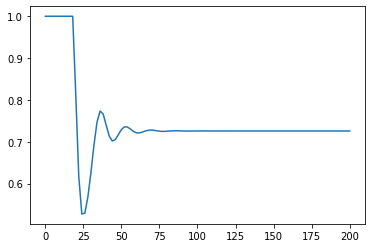

In [77]:
plt.plot(t,out['phi'])

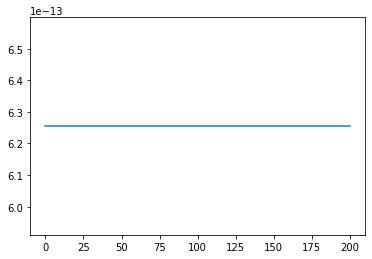

In [78]:
plotted_ting = pd.Series(np.zeros(len(vessel_data_alltime)))
for i in range(len(vessel_data_alltime)):
    plotted_ting[i] = vessel_data_alltime[i].loc[6,'Diameter(µm)']

plt.plot(t,plotted_ting)

In [79]:
plotted_ting

0      6.255039e-13
1      6.255039e-13
2      6.255039e-13
3      6.255039e-13
4      6.255039e-13
           ...     
96     6.255039e-13
97     6.255039e-13
98     6.255039e-13
99     6.255039e-13
100    6.255039e-13
Length: 101, dtype: float64

In [80]:
out.loc[50,'phi']

0.7258854578824169

In [81]:
baselines

,Name,Number,Diameter(µm),Length(µm),Viscocity(mPAs),Pressure Drop(mmHg),Saturation,dS,Resistance for U,Resistance for Q,U in single(m/s????),baseline Q,Vt,partial pressure blood(mmHg),X-Area wall(mm^2?),wall thickness(µm),tissue partials(mmHg)
0,A1,1,23.97,1267.6,1.59,6.93,0.9400,0.01000,112.251787,0.248752,0.061736,27.859025,78005.271056,70.871373,438.213672,4.841407,68.497559
1,A2,2,19.17,930.3,1.50,5.87,0.9300,0.01000,121.512242,0.421004,0.048308,13.942870,39040.035790,67.005340,313.016429,4.253658,65.226941
2,A3,4,15.28,543.6,1.42,4.02,0.9200,0.02000,105.796442,0.576945,0.037997,6.967734,39019.312012,63.786724,228.546291,3.810683,60.367867
3,A4,8,12.08,302.3,1.34,2.70,0.8900,0.04000,88.829876,0.775060,0.030395,3.483601,39016.335895,56.550348,170.463521,3.485850,49.437369
4,A5,16,9.46,161.2,1.28,1.82,0.8400,0.06250,73.780690,1.049713,0.024668,1.733807,30341.627914,48.706014,130.572935,3.265971,36.295309
5,A6,32,7.32,154.7,1.23,2.35,0.7650,0.08750,113.637911,2.700295,0.020680,0.870275,21321.745183,41.211431,103.110791,3.138293,29.926051
6,C,64,8.00,243.9,1.24,2.62,0.6650,0.07750,302.436000,6.016773,0.008663,0.435449,9449.251212,34.556920,111.338044,3.172168,31.622967
7,V6,32,11.51,473.9,1.33,1.27,0.6100,0.03375,152.243122,1.463178,0.008342,0.867974,8202.351518,31.696836,161.197683,3.433626,30.710714
8,V5,16,14.53,272.3,1.40,0.61,0.5975,0.01125,57.782247,0.348476,0.010557,1.750477,5514.003939,31.097186,214.009514,3.730525,30.104242
9,V4,8,17.79,426.6,1.48,0.89,0.5875,0.00750,63.838202,0.256826,0.013941,3.465382,7277.302540,30.628584,281.309064,4.092089,29.879173
